# Task 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import numpyro
import seaborn as sns
import matplotlib.pyplot as plt

/home/emac/PROJETS_PERSO/Optimize-market-spending-LightweightMMM/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

2025-02-09 14:36:15.751441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739108175.762046   77261 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739108175.764870   77261 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Task 2: Load the Dataset

In [3]:
data = pd.read_csv("data.csv")
data.head()

,Date,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
0,2021-01-08,26865.0,3426.0,1861.0,1287.0,1432.0,1532.0
1,2021-01-15,22850.0,2912.0,1919.0,1022.0,1278.0,1682.0
2,2021-01-22,32856.0,5150.0,4161.0,1123.0,1615.0,778.0
3,2021-01-29,35756.0,1416.0,1097.0,1129.0,1284.0,1142.0
4,2021-02-05,29125.0,3093.0,3544.0,817.0,1171.0,1163.0


# Task 3: Explore the Dataset

In [4]:
# check for missing values
data.isna().sum()

Date                    0
Sales                   0
adwords_spending        2
facebookads_spending    2
awin_spending           2
tiktok_spending         2
snapchat_spending       2
dtype: int64

In [5]:
data.describe()

,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
count,156.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,35268.814103,3206.240260,2983.389610,1448.909091,1239.162338,1473.337662
std,6350.950726,1217.082255,1078.147608,510.092474,424.362536,484.917569
min,22077.000000,1378.000000,1070.000000,597.000000,451.000000,600.000000
25%,31925.750000,2133.250000,2032.000000,1017.250000,889.750000,1079.250000
50%,34442.000000,3038.500000,3097.500000,1312.500000,1221.000000,1517.000000
75%,37875.500000,4155.500000,3820.500000,1848.000000,1592.500000,1857.750000
max,72194.000000,6024.000000,5691.000000,3207.000000,2753.000000,2574.000000


In [6]:
correlation_matrix = data.corr(numeric_only=True).round(2)
correlation_matrix

,Sales,adwords_spending,facebookads_spending,awin_spending,tiktok_spending,snapchat_spending
Sales,1.00,0.13,0.13,0.35,0.46,0.33
adwords_spending,0.13,1.00,0.10,0.11,0.06,0.00
facebookads_spending,0.13,0.10,1.00,-0.04,0.17,0.10
awin_spending,0.35,0.11,-0.04,1.00,0.16,0.19
tiktok_spending,0.46,0.06,0.17,0.16,1.00,0.10
snapchat_spending,0.33,0.00,0.10,0.19,0.10,1.00


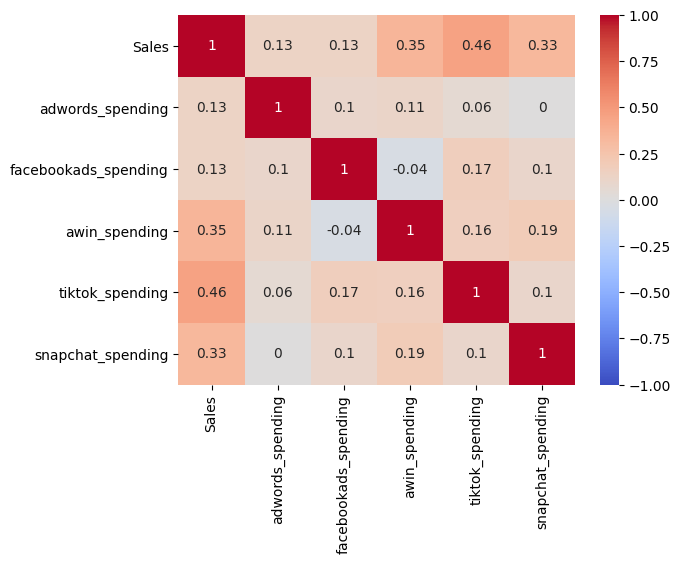

In [7]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

<AxesSubplot: xlabel='Date'>

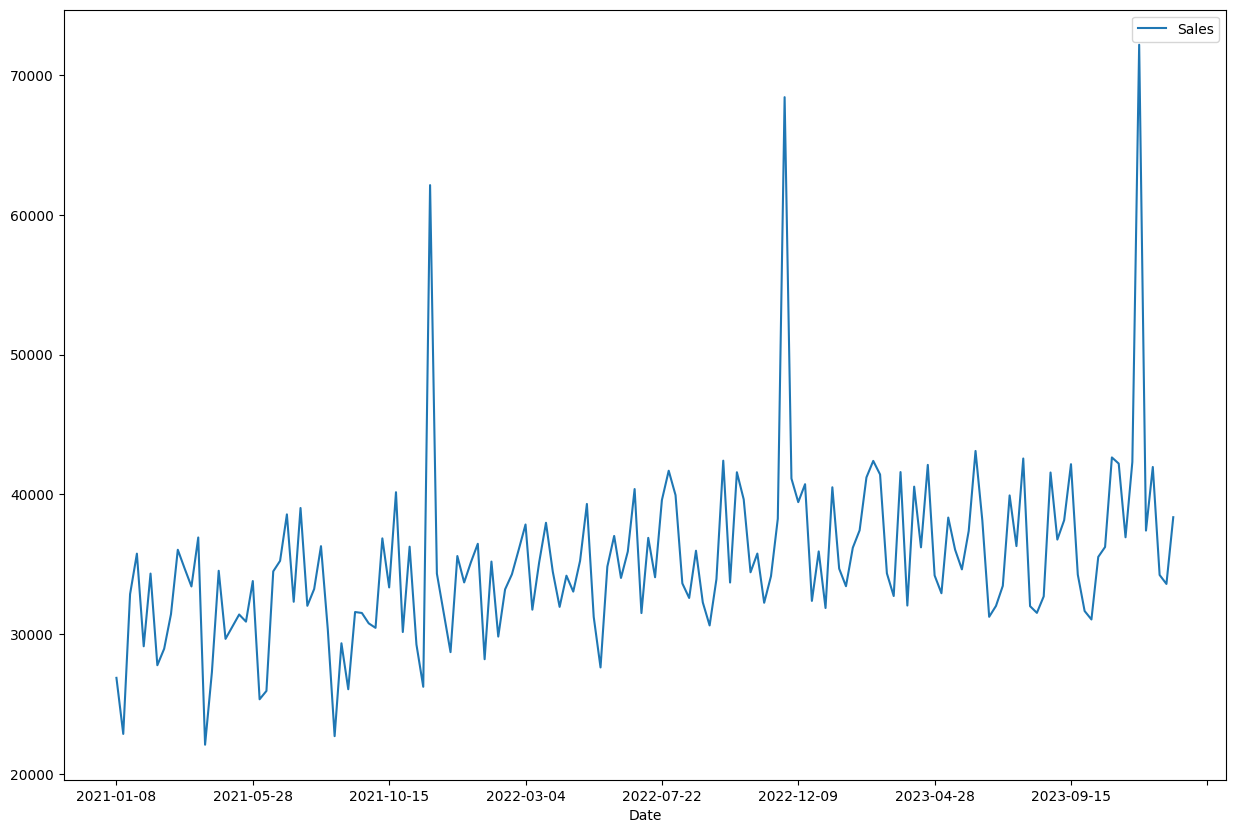

In [8]:
data.plot.line(x="Date", y="Sales", figsize=(15, 10))

# Task 4: Preprocess the Data

In [9]:
data["Date"] = pd.to_datetime(data["Date"])

In [10]:
black_friday_dates = [
    pd.Timestamp('2021-11-26'),
    pd.Timestamp('2022-11-25'),
    pd.Timestamp('2023-11-24')
]

data["black_friday"] = data["Date"].isin(black_friday_dates).astype(int)

In [11]:
data.fillna(0, inplace=True)

In [12]:
n = data.shape[0]
split_point = int(n*0.8)
train = data[:split_point]
test = data[split_point:]

In [13]:
media = ["adwords_spending", "facebookads_spending", "awin_spending", "tiktok_spending", "snapchat_spending"]
extra_features = ["black_friday"]
target = ["Sales"]
costs = np.ones(5)

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

extra_feature_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

scaled_costs = cost_scaler.fit_transform(np.array(costs))

scaled_media_train = media_scaler.fit_transform(train[media].to_numpy())

scaled_extra_features_train = extra_feature_scaler.fit_transform(train[extra_features].to_numpy())

scaled_target_train = target_scaler.fit_transform(train[target].to_numpy())

scaled_media_test = media_scaler.transform(test[media].to_numpy())
scaled_extra_features_test = extra_feature_scaler.transform(test[extra_features].to_numpy())

scaled_target_test = target_scaler.transform(test[target].to_numpy())

# Task 5: Train a Marketing Mix Model

In [38]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [39]:
numpyro.set_host_device_count(2)
mmm.fit(media=scaled_media_train,
extra_features=scaled_extra_features_train,
    media_prior=scaled_costs,
    target=scaled_target_train,
    number_warmup=200,
    number_samples=500,
    number_chains=1)

sample: 100%|██████████| 700/700 [00:23<00:00, 29.61it/s, 1023 steps of size 8.36e-04. acc. prob=0.96]


# Task 6: Check for Convergence

In [40]:
# Print the model summary
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.00      0.00     -0.00     -0.00      0.00    447.90      1.00
                      coef_media[0]      0.09      0.05      0.08      0.02      0.15      2.55      2.46
                      coef_media[1]      0.12      0.03      0.11      0.07      0.16      4.76      1.43
                      coef_media[2]      0.04      0.01      0.03      0.02      0.05      8.80      1.02
                      coef_media[3]      0.01      0.01      0.01      0.00      0.02      6.20      1.48
                      coef_media[4]      0.04      0.01      0.04      0.02      0.06      9.04      1.04
                      coef_trend[0]     -0.00      0.00     -0.00     -0.00     -0.00      7.10      1.28
                         expo_trend      1.15      0.01      1.15      1.13      1.17      5.69      1.16
             gamma_seasonality[0,0]     -0.00

# Task 7: Evaluate the Model

In [41]:
# Use the model to get predictions for the test set
prediction=mmm.predict(
        media=test[media].to_numpy(),
        extra_features=test[extra_features].to_numpy(),
        target_scaler=target_scaler
    )

In [42]:
# Get the mean value of those predictions for each data point
prediction_mean=np.mean(prediction,axis=0)

In [43]:
# Calculate and print the RMSE
rmse=np.sqrt(
    np.mean(pow(test["Sales"]-prediction_mean , 2))
)
print(rmse)

7327.5107


# Task 8: Check for Prediction Quality

In [44]:
# Extract the average and range of predictions
avg_predictions = np.mean(prediction, axis=0)
std_dev_predictions = np.std(prediction, axis=0)
range_predictions = std_dev_predictions*2

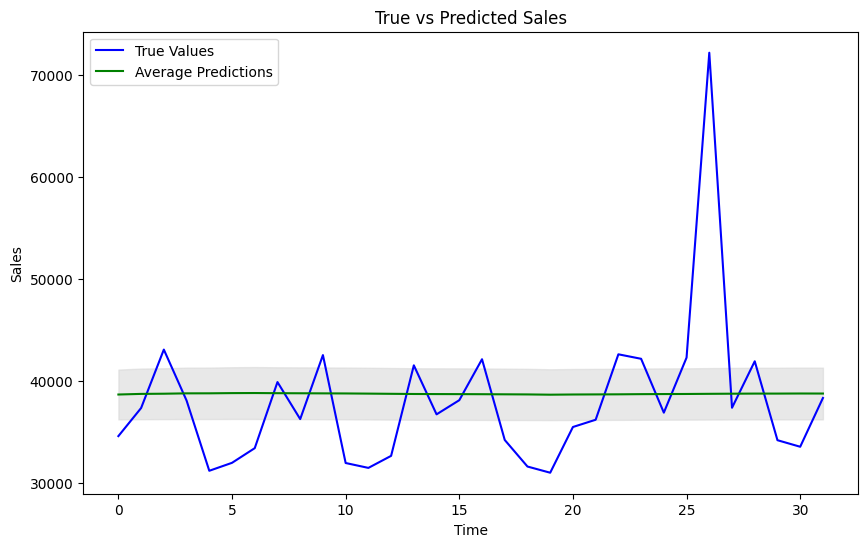

In [45]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
  test["Sales"].reset_index(drop=True),
  label="True Values", color='blue')
plt.plot(
  avg_predictions,
  label="Average Predictions",
  color='green')
plt.fill_between(
  range(len(avg_predictions)),
  avg_predictions - range_predictions,
  avg_predictions + range_predictions,
  color='lightgrey', alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("True vs Predicted Sales")
plt.legend()
plt.show()

# Task 9: Check Parameter Estimations

/tmp/ipykernel_77261/3186814276.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  plot.plot_prior_and_posterior(


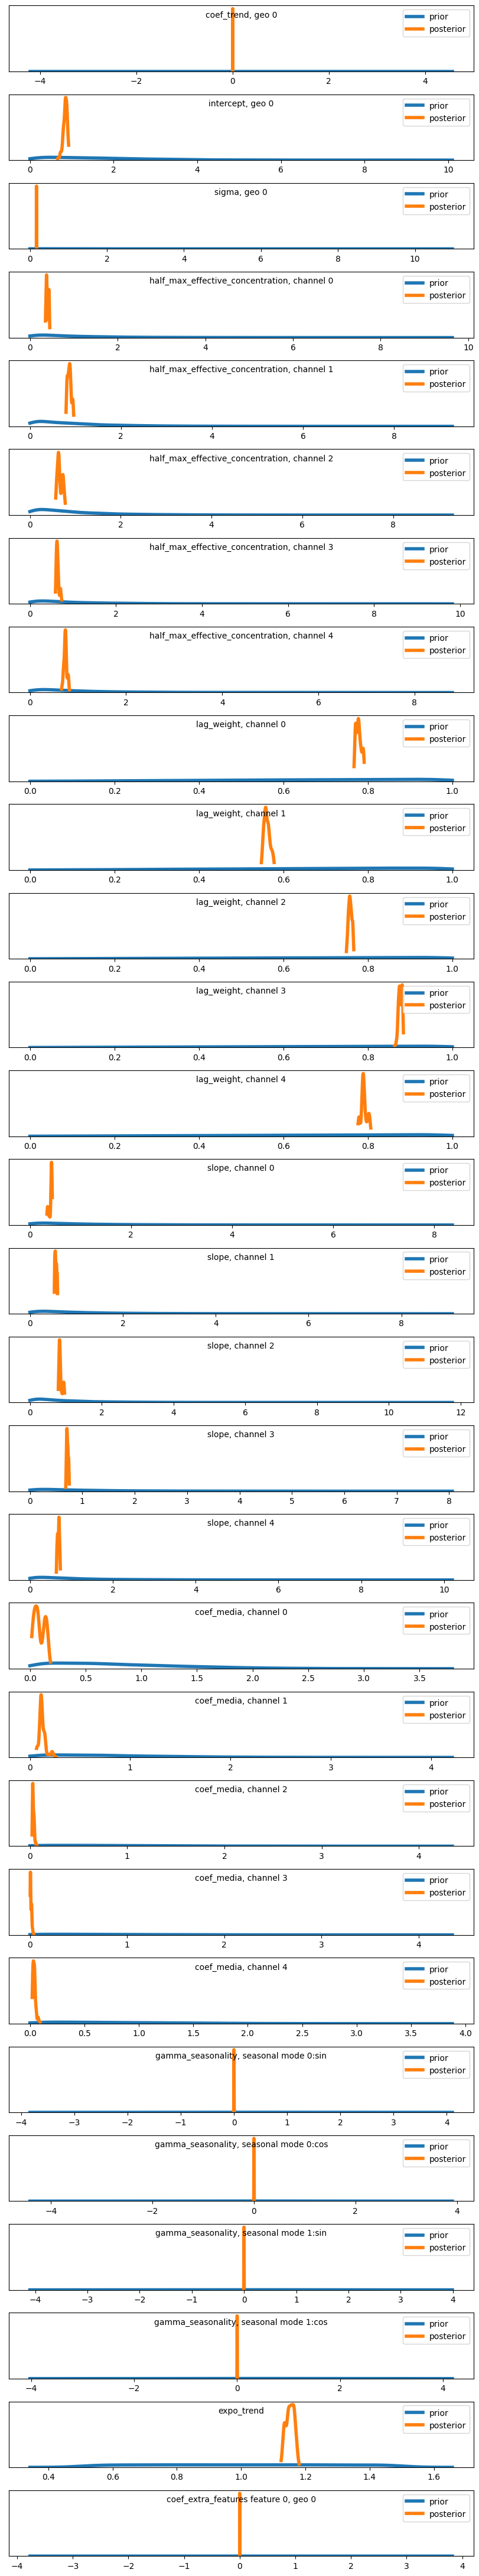

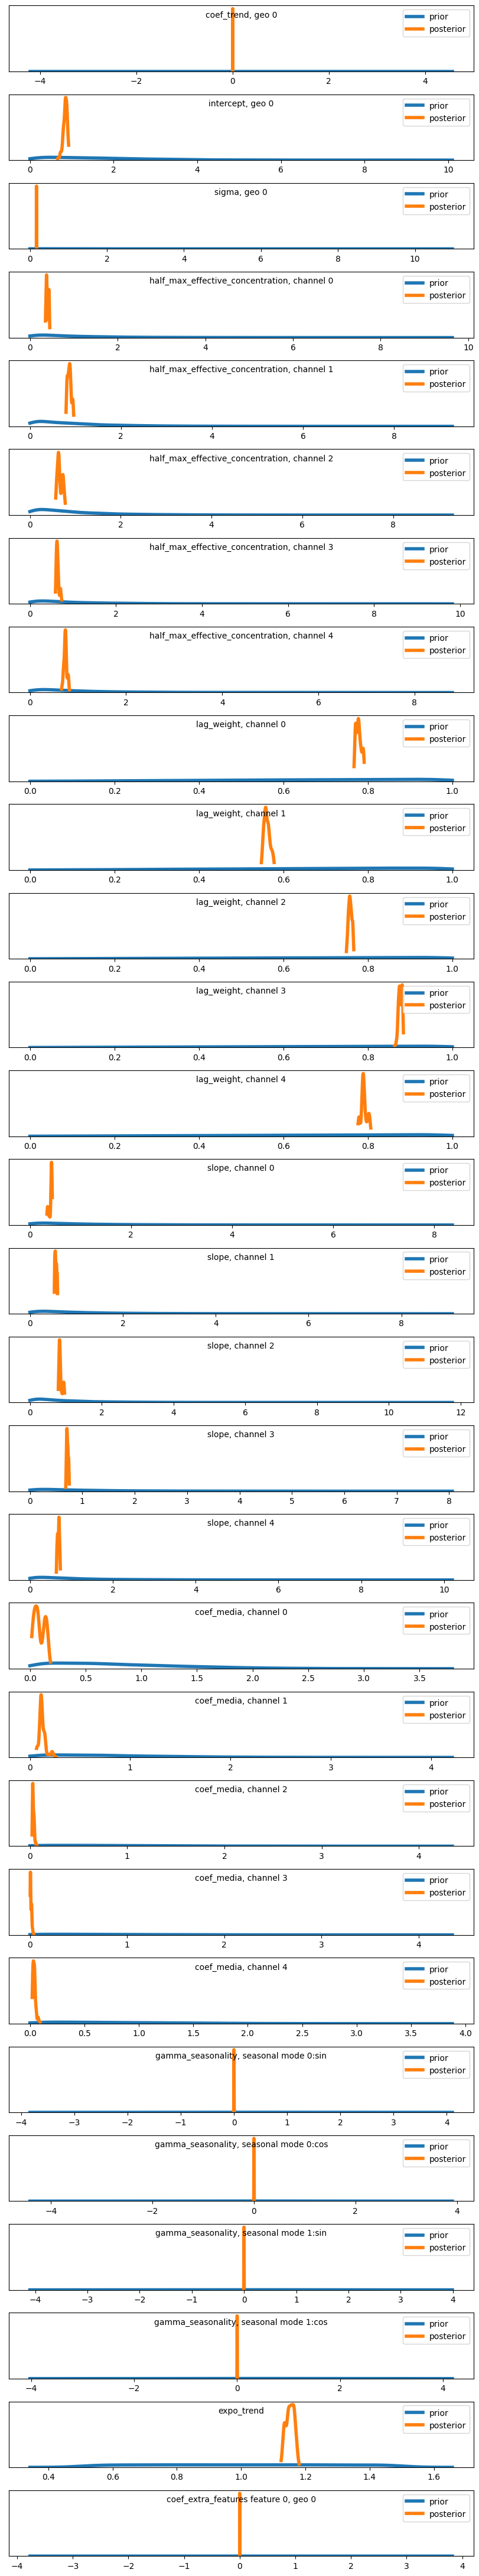

In [46]:
# Plot media channel priors vs. posteriors
plot.plot_prior_and_posterior(
media_mix_model=mmm)

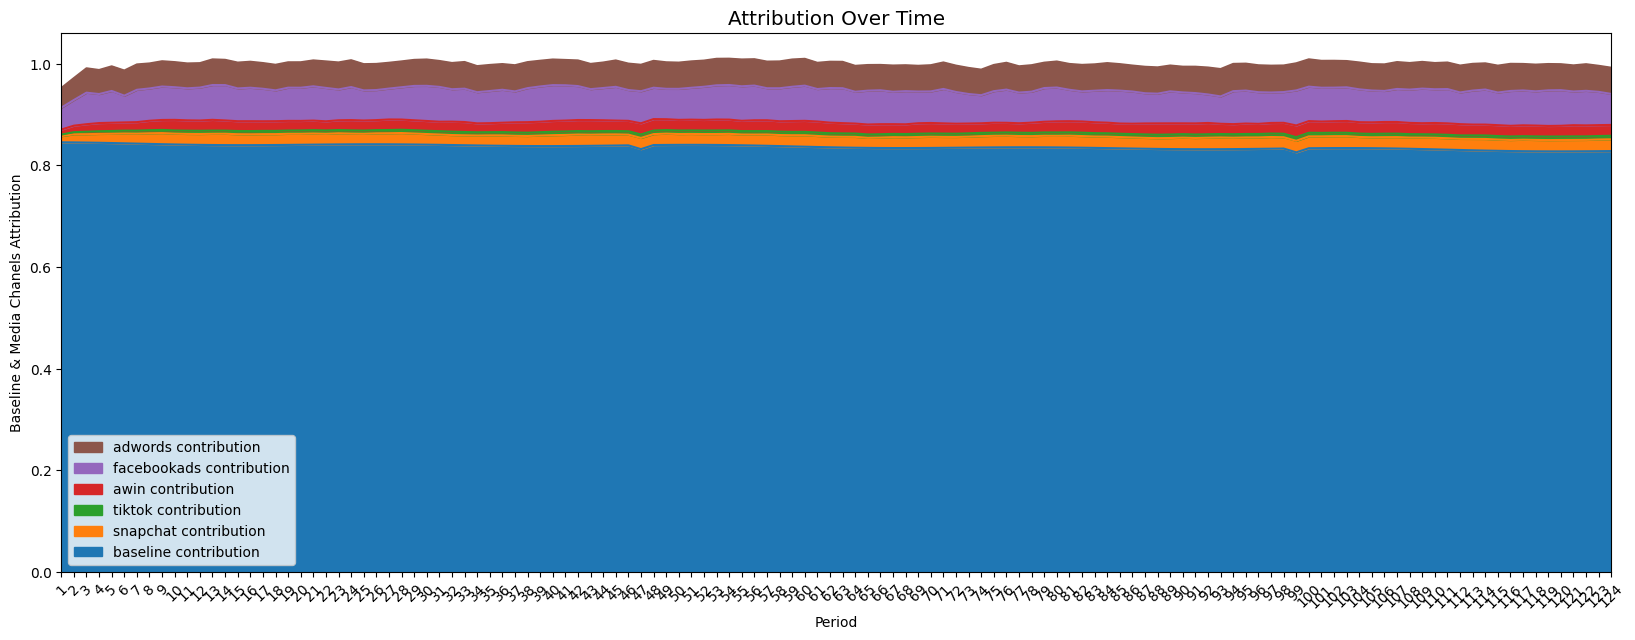

In [47]:
# Plot the media baseline contributions
plot.plot_media_baseline_contribution_area_plot(
  media_mix_model=mmm,
  channel_names=[name.replace("_spending","") for name in media])

# Task 10: Assess Model Insights

In [48]:
# Get the estimators for media effect and ROI
media_effect_hat, roi_hat = mmm.get_posterior_metrics(
target_scaler=target_scaler,
cost_scaler=cost_scaler
)

In [49]:
# Calculate and print their mean values
mean_roi = np.mean(roi_hat, axis=0)
mean_media_effect = np.mean(media_effect_hat, axis=0)

print(mean_roi)
print(mean_media_effect)

[220159.5   274072.1    87329.02   28051.484  92447.03 ]
[0.05135065 0.06392104 0.02036704 0.00654252 0.02156105]


# Task 11: Optimize Media Spending

In [50]:
# Define a time frame and a budget
time_frame = len(test.Date)

# Define a budget
avg_budget = train[media].mean().sum()
budget = avg_budget * time_frame

# Run media optimization
solution = optimize_media.find_optimal_budgets(
    n_time_periods=time_frame,
    media_mix_model=mmm,
    budget=budget,
    extra_features=scaled_extra_features_test,
    prices=costs,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    bounds_upper_pct=10
    )

print(solution)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1100768.4276767566
            Iterations: 45
            Function evaluations: 496
            Gradient evaluations: 45
( message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1100768.4276767566
       x: [ 8.100e+04  1.219e+05  4.829e+04  3.022e+04  4.313e+04]
     nit: 45
     jac: [-1.078e-01 -1.503e-01 -1.503e-01 -5.538e-02 -1.503e-01]
    nfev: 496
    njev: 45, Array(-1098328.85008267, dtype=float64), Array([101249.28863005,  94431.48397167,  45268.6443379 ,  37776.25765115,
        45796.90605439], dtype=float64))


# Note:
The value for func is the inverse of the expected sales after optimization. If func is equal to -300000, it means the model estimates US$300,000 in sales, given the proposed budget allocations. This is because the solver uses minimization instead of maximization.

# Task 12: Persist the Model

In [52]:
# Save the model
utils.save_model(mmm,'First_MMMM_Model')

In [54]:
# Load the model and print its summary
imported_mmm= utils.load_model('First_MMMM_Model')
imported_mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.00      0.00     -0.00     -0.00      0.00    447.90      1.00
                      coef_media[0]      0.09      0.05      0.08      0.02      0.15      2.55      2.46
                      coef_media[1]      0.12      0.03      0.11      0.07      0.16      4.76      1.43
                      coef_media[2]      0.04      0.01      0.03      0.02      0.05      8.80      1.02
                      coef_media[3]      0.01      0.01      0.01      0.00      0.02      6.20      1.48
                      coef_media[4]      0.04      0.01      0.04      0.02      0.06      9.04      1.04
                      coef_trend[0]     -0.00      0.00     -0.00     -0.00     -0.00      7.10      1.28
                         expo_trend      1.15      0.01      1.15      1.13      1.17      5.69      1.16
             gamma_seasonality[0,0]     -0.00

In [55]:
# Use the model to make predictions on the test set
predictions_imported=imported_mmm.predict(
        media=test[media].to_numpy(),
        extra_features=test[extra_features].to_numpy(),
        target_scaler=target_scaler
)

In [56]:
avg_prediction = np.mean(predictions_imported, axis=0)
print(avg_prediction)

[38706.273 38767.004 38784.79  38820.543 38823.887 38843.812 38851.78
 38836.26  38827.996 38819.258 38810.547 38794.37  38775.32  38758.13
 38749.52  38744.773 38736.973 38726.023 38715.387 38689.348 38708.12
 38716.734 38725.203 38742.242 38751.49  38759.44  38774.457 38786.742
 38796.863 38797.305 38805.61  38801.734]
